In [1]:
# Break down rallies into shot sequences
# Basic algorithm:
# - Use feet position to hash the 2d location where a shot was hit
# - Extract out maximal shot sequences from all the rallies we have

# Basic algorithm:
# - Create databases of 1,2,3,...,n shot sequences
# - Given a shot diagram compute a similarity score between that diagram and all known shot sequences
# - Return statistics:
#     - top-k most similar sequences
#     - shot return probabilities for each area of the court (and probability of winning)


In [1]:
# %matplotlib inline
%matplotlib widget
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np
import cv2
import errno

from ai_badminton.trajectory import Trajectory
from ai_badminton.hit_detector import AdhocHitDetector, MLHitDetector
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.video_annotator import annotate_video
from ai_badminton.shots import *

In [11]:
# Build shot database from rallies
matches = list('match' + str(i) for i in range(1, 27))

manual_label = {
    ('match1', '1_02_04'): 2,
    ('match1', '1_06_08'): 1,
    ('match1', '1_02_02'): 1,
    ('match1', '1_02_01'): 2,
    ('match1', '1_03_04'): 2,
    ('match1', '1_02_03'): 1,
    ('match3', '1_08_10'): 2,
    ('match8', '3_02_00'): 2,
}

nframe = 0
sequences = []
for match in matches:
    for video in os.listdir('/home/code-base/scratch_space/data/%s/rally_video/' % match):
        rally, _ = os.path.splitext(video)
        cap = cv2.VideoCapture('/home/code-base/scratch_space/data/%s/rally_video/%s.mp4' % (match, rally))
        nframe += int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        try:
            court_pts = read_court('/home/code-base/scratch_space/data/%s/court/%s.out' % (match, rally))
            corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]
            court = Court(corners)
            trajectory = Trajectory(
                '/home/code-base/scratch_space/data/%s/ball_trajectory/%s_ball.csv' % (match, rally)
            )

            hits = pd.read_csv('/home/code-base/scratch_space/data/%s/shot/%s_hit.csv' % (match, rally))
            poses = read_player_poses('/home/code-base/scratch_space/data/%s/poses/%s' % (match, rally))
        except:
            continue
            
        # Identify first hit by distance to pose
        # and then alternate hits
        def dist_to_pose(pose, p):
            pose = pose.reshape(17, 2)
            p = p.reshape(1, 2)
            D = np.sum((pose - p) * (pose - p), axis=1)
            return min(D)
        
        hits = np.array(hits.hit.to_numpy())
        # Majority vote for who started the rally
        # If hit number is odd, then whoever started the rally
        # is the opposite of whoever was detected.
        votes = [0, 0]
        best_dist = [1e99, 1e99]
        nhit = 0
        for i in range(hits.shape[0]):
            if not hits[i]:
                continue
            
            p = np.array([trajectory.X[i], trajectory.Y[i]])
            db = dist_to_pose(poses[0].values[i], p)
            dt = dist_to_pose(poses[1].values[i], p)
            person = 0
            if db < dt:
                person = 1
            else:
                person = 2
            
            if nhit % 2:
                person = 3 - person
                
            votes[person - 1] += 1
            best_dist[person - 1] = min(best_dist[person - 1], min(db, dt))
            
            nhit += 1
            
        last = 2 if votes[0] > votes[1] else 1
        if (match, rally) in manual_label:
            last = 3 - manual_label[match, rally]
            
        for i in range(hits.shape[0]):
            if not hits[i]:
                continue
                
            hits[i] = 3 - last
            last = hits[i]
                
        # Generate arrays of which frames the shuttles were hit and who hit it
        hit_frame, who_hit = [], []
        L = hits.shape[0]
        for i in range(L):
            if hits[i]:
                hit_frame.append(i)
                who_hit.append(hits[i])
                
        # Assume the rally ends 4 frames from the end
        hit_frame.append(L - 4)
        who_hit.append(3)
        sequence = generate_sequence(
            court, trajectory, poses, (hit_frame, who_hit)
        )
        sequences.append([match, video, sequence])

In [12]:
nframe

78921

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
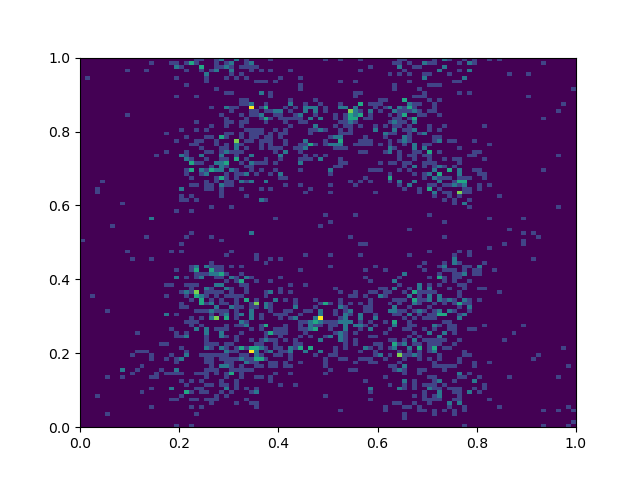

In [3]:
x = [s[1][0] for seq in sequences for s in seq[2]]
y = [s[1][1] for seq in sequences for s in seq[2]]
plt.hist2d(x, y, bins=100, range=[[0,1], [0,1]])

Text(0.5, 1.0, 'x_hit distribution')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
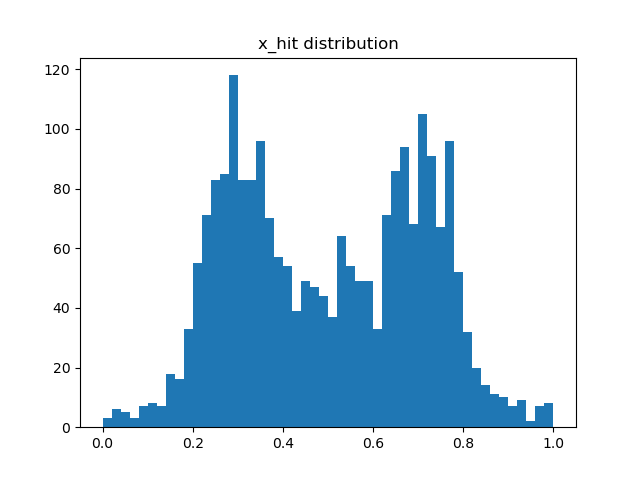

In [4]:
fig1 = plt.figure()
plt.hist(x, bins=50, range=(0,1))
plt.title('x_hit distribution')

Text(0.5, 1.0, 'y_hit distribution')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
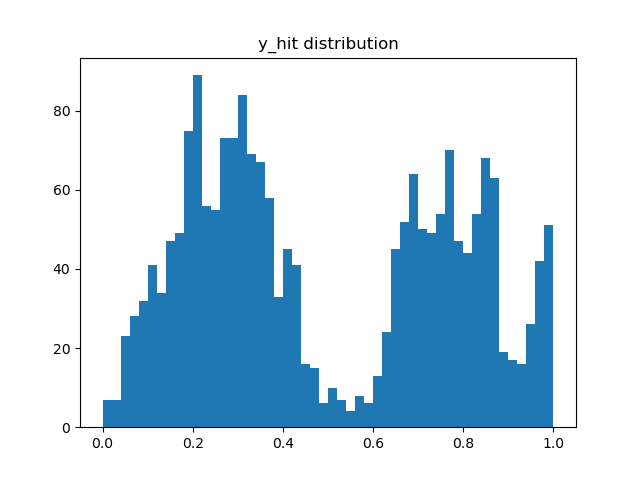

In [5]:
fig2 = plt.figure()
plt.hist(y, bins=50, range=(0,1))
plt.title('y_hit distribution')

IntProgress(value=0, description='Saving...', style=ProgressStyle(bar_color='maroon'))

Textarea(value='', description='Status:', placeholder='')

Video(value=b'')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
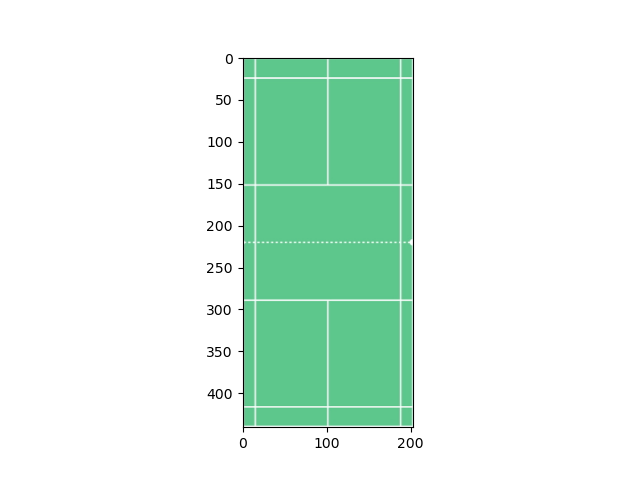

In [12]:
import ipywidgets as wdg  # Using the ipython notebook widgets
import copy

frame = cv2.imread('./court.jpg')
height, width = frame.shape[0], frame.shape[1]

from matplotlib.backend_bases import MouseButton
# Let's manually pick out the court pixel coordinates first
fig = plt.figure()
plt.imshow(frame)

# Create and display textarea widget
txt = wdg.Textarea(
    value='',
    placeholder='',
    description='Status:',
    disabled=False
)

def create_subsequences(seqs):
    res = []
    for seq in seqs:
        for i in range(len(seq[2])):
            res.append([seq[0], seq[1], seq[2][i:]])
    return res

# A basic UI function to store the court
curr_vid, tot_vid = 0, 0
video = wdg.Video()

subsequences = create_subsequences(sequences)
points, frames, shots = [], [], []

def reset_state(event):
    global points, frames, shots
    points = []
    frames = [frame]
    shots = [ShotFilter(subsequences)]
    plt.imshow(frames[-1])

reset_button = wdg.Button(
    description='Reset state',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset state',
    icon='trash' # (FontAwesome names without the `fa-` prefix)
)
reset_button.on_click(reset_state)
reset_state(None)

bar = wdg.IntProgress(
    value=0,
    min=0,
    max=100,
    description='Saving...',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'maroon'},
    orientation='horizontal'
)

def save_rally(path, seq, nshots):
    try:
        os.makedirs('output')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    
    invid = cv2.VideoCapture('/home/code-base/scratch_space/data/%s/rally_video/%s' % (seq[0], seq[1]))
    
    fps = int(invid.get(cv2.CAP_PROP_FPS))
    width  = int(invid.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
    height = int(invid.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    outvid = cv2.VideoWriter(path, fourcc, fps, (width, height))

    t0, t1 = max(seq[2][0][0]-10, 0), min(seq[2][nshots-1][0]+10, invid.get(cv2.CAP_PROP_FRAME_COUNT) - 1)
    invid.set(cv2.CAP_PROP_POS_FRAMES, t0)
    for t in range(int(t0), int(t1)+1):
        ret, frame = invid.read()
        outvid.write(frame)
    outvid.release()
    os.system("ffmpeg -i %s -vcodec libx264 tmp.mp4" % path)
    os.system("mv tmp.mp4 %s" % path)
    
debug = []
def save_search(event):
    global curr_vid, tot_vid
    txt.value = 'Preparing to save rallies...'
    for f in os.listdir('./output/rallies/'):
        if f[-3:] != 'mp4':
            continue
        os.remove(os.path.join('./output/rallies', f))
        txt.value = 'Removing old file ' + f + '...'
    bar.value = 0
    txt.value = 'Saving rallies..'
    for s, seq in enumerate(shots[-1].result):
        debug.append(seq)
        save_rally('./output/rallies/rally'+str(s)+'.mp4', seq, len(points))
        bar.value = int(s/len(shots[-1].result) * 100)
    bar.value = 100
    if shots[-1].result:
        video.set_value_from_file('./output/rallies/rally0.mp4')
        tot_vid = len(shots[-1].result)
        curr_vid = 0
    
save_button = wdg.Button(
    description='Save search',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save state',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
save_button.on_click(save_search)

def set_video(event, move=1):
    global curr_vid, tot_vid
    if move < 0:
        move = tot_vid + move
    curr_vid = (curr_vid + move) % tot_vid
    video.set_value_from_file('./output/rallies/rally%d.mp4' % curr_vid)
    txt.value = 'Playing video %d / %d:' % (curr_vid + 1, tot_vid)
    
next_button = wdg.Button(
    description='Next video',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Next video',
    icon='arrow-right' # (FontAwesome names without the `fa-` prefix)
)
prev_button = wdg.Button(
    description='Previous video',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Previous video',
    icon='arrow-left' # (FontAwesome names without the `fa-` prefix)
)
next_button.on_click(lambda e: set_video(e, 1))
prev_button.on_click(lambda e: set_video(e, -1))

# Order of display
display(wdg.HBox((save_button, reset_button, next_button, prev_button)))
display(bar)
display(txt)
display(video)

def draw_dot(x, y):  
    centre = (int(x), int(y))
    radius = 5
    colour = (255, 0, 0)
    thickness = -1
    frame_next = cv2.circle(frames[-1].copy(), centre, radius, colour, thickness)
    if len(points):
        frame_next = cv2.arrowedLine(frame_next, points[-1], centre, (128, 127, 0))
    
    shot_filter = copy.deepcopy(shots[-1])
    shot_filter.add_shot((x / width, 1 - y / height))
    
    points.append(centre)
    frames.append(frame_next)
    shots.append(shot_filter)
    txt.value = '# sequences found: ' + str(len(shots[-1].result)) + \
                '\nLast shot in zone ' + str(zone((x / width, 1 - y / height)))
    plt.imshow(frames[-1])

def undraw_dot():
    if len(frames) > 1:
        frames.pop()
        points.pop()
        shots.pop()
    plt.imshow(frames[-1])
    txt.value = '# sequences found: ' + str(len(shots[-1].result))

def onclick(event):
    txt.value = str(event)  # Dynamically update the text box above
    if event.button == MouseButton.LEFT:
        x, y = event.xdata, event.ydata
        draw_dot(x, y)
    elif event.button == MouseButton.RIGHT:
        if len(frames) > 1:
            undraw_dot()

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)